In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pycbc
from pycbc.types import FrequencySeries
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform

from gstlal import chirptime
from functools import partial


import h5py
import scipy

import bilby
from bilby.gw import utils as gwutils
from pesummary.gw.conversions import spins as pespin
from multiprocessing import Pool
import multiprocessing
from functools import partial
from bilby.gw import conversion

import torch
import os
# cit: '/home/qian.hu/neuron_process_waveform/npf_GWwaveform'
# local: '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/'
try:
    os.chdir('/home/qian.hu/neuron_process_waveform/npf_GWwaveform/')
except:
    os.chdir('/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/')
from gw.utils import gwutils as npgwutils


# Single waveform context

In [22]:
duration=32/4
f_lower=10*2
sampling_frequency=4096
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 1,
 'a_1': 0.48817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

approx = 'IMRPhenomXPHM' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SEOBNRv4PHM' # SEOBNRv4PHM SEOBNRv4P
f_ref = 50
f_lower = 20
waveform_arguments = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments_under = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments)

waveform_generator_under = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments_under)

In [23]:
h_dict_imr = waveform_generator.frequency_domain_strain(injection_parameters)
h_dict_eob = waveform_generator_under.frequency_domain_strain(injection_parameters)

In [24]:
# local
path_local_PHM = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'

# cit
path_cit_PHM = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'

np_model_path = path_local_PHM
waveform_generator_np = npgwutils.NPWaveformGenerator(model_path=np_model_path,
                                                      context_waveform_generator=waveform_generator,device='cpu')

waveform_generator_np2 = npgwutils.NPWaveformGenerator(model_path=np_model_path,
                                                       context_waveform_generator=waveform_generator_under,device='cpu')


--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 95 | train loss: 8215.8128 | valid loss: 9618.0331 | test log likelihood: -8821.4857

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 95 | train loss: 8525.2475 | valid loss: 9923.1221 | test log likelihood: -9354.2217

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 87 | train loss: 10729.9055 | valid loss: 12006.9353 | test log likelihood: -11772.4798

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 97 | train loss: 11306.5291 | valid loss: 12728.3657 | test log likelihood: -12339.914

--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 95 | train loss: 8215.8128 | valid loss: 9618.0331 | test log likelihood: -8821.4857

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 95 | train loss: 8525.2475 | valid loss: 9923.1221 | test log likelihood: -9354.2217



In [25]:
h_dict, error_dict = waveform_generator_np.frequency_domain_strain(injection_parameters)

h_dict2, error_dict2 = waveform_generator_np2.frequency_domain_strain(injection_parameters)

/Users/qianhu/opt/anaconda3/envs/igwn-py39/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [26]:
for key in ['plus', 'cross']:
    h_dict_eob[key] = npgwutils.get_shifted_h2_zeropad(h_dict_imr[key], h_dict_eob[key], det)

(20.0, 40.0)

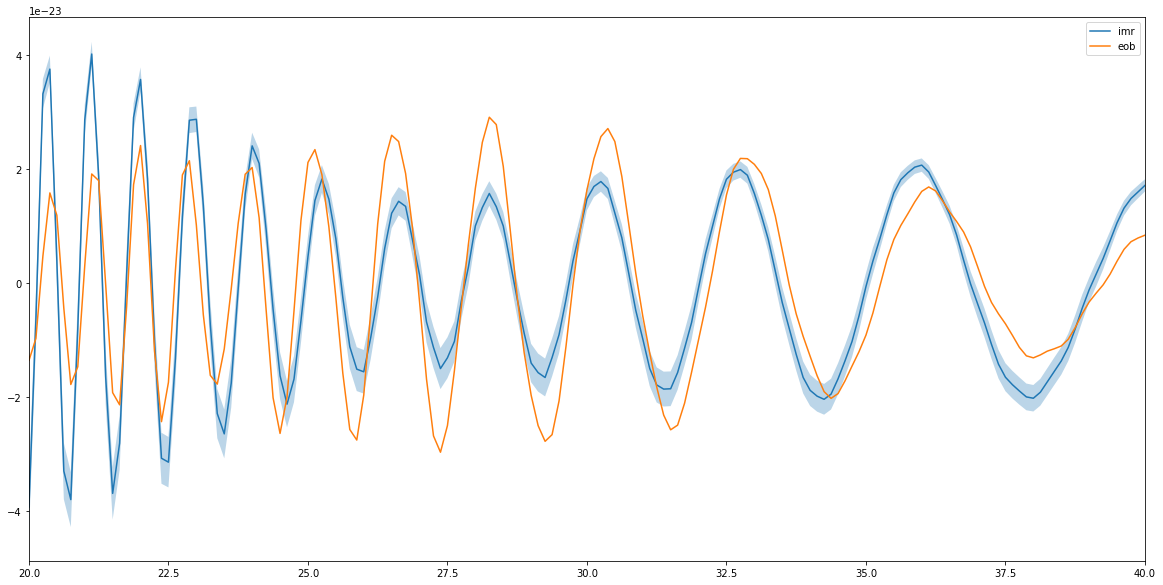

In [27]:
plt.figure(figsize=(20,10))

mode = 'cross'
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict[mode]), label='np')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
                 alpha=0.3 )
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict_imr[mode]), label='imr')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
                 alpha=0.3 )

plt.plot(waveform_generator.frequency_array, np.real(h_dict_eob[mode]), label='eob')

plt.legend()
#plt.xlim(40,100)
plt.xlim(20,40)

(20, 2000)

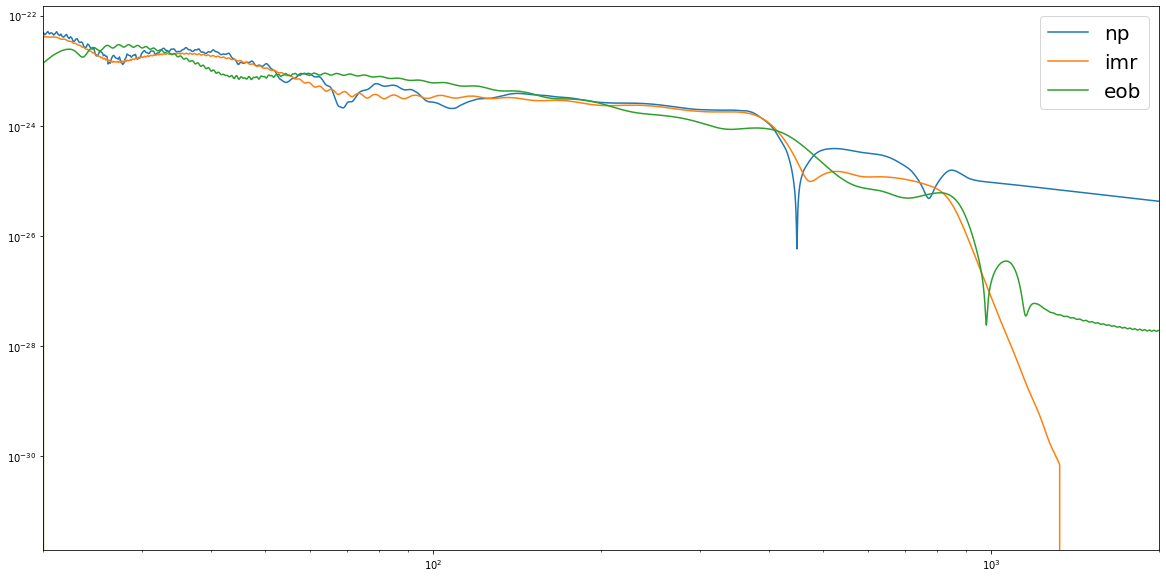

In [28]:
plt.figure(figsize=(20,10))

mode = 'cross'
plt.loglog(waveform_generator.frequency_array, np.abs(h_dict[mode]), label='np')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator.frequency_array, np.abs(h_dict_imr[mode]), label='imr')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator.frequency_array, np.abs(h_dict_eob[mode]), label='eob')

plt.legend(fontsize=20)
plt.xlim(20,2000)

(20.0, 50.0)

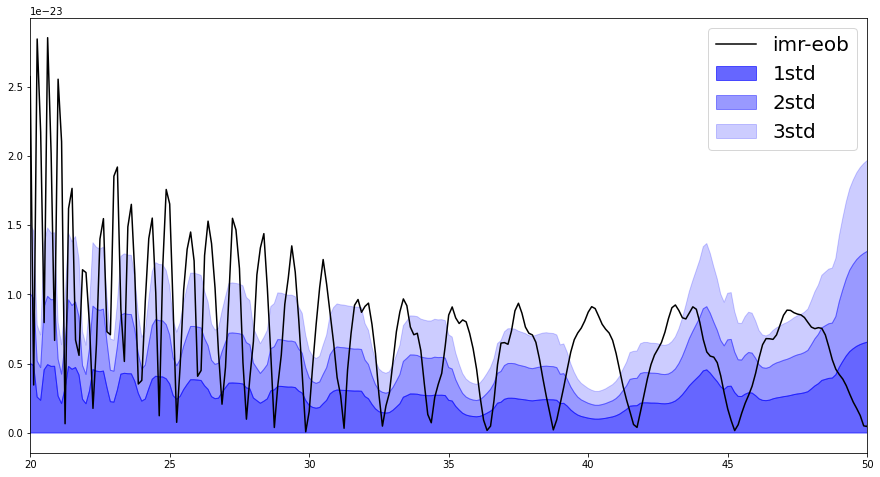

In [29]:
plt.figure(figsize=(15,8))

mode = 'cross'


plt.plot(waveform_generator.frequency_array, abs(np.real(h_dict_imr[mode]-h_dict_eob[mode])), label='imr-eob', color='k')

plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict[mode]), label=f'1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.4, color='b', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'3std', alpha=0.2, color='b')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)

In [30]:
for key, errors in error_dict2.items():
    error_dict2[key] = npgwutils.get_shifted_h2_zeropad(error_dict[key], error_dict2[key], det)

(20.0, 50.0)

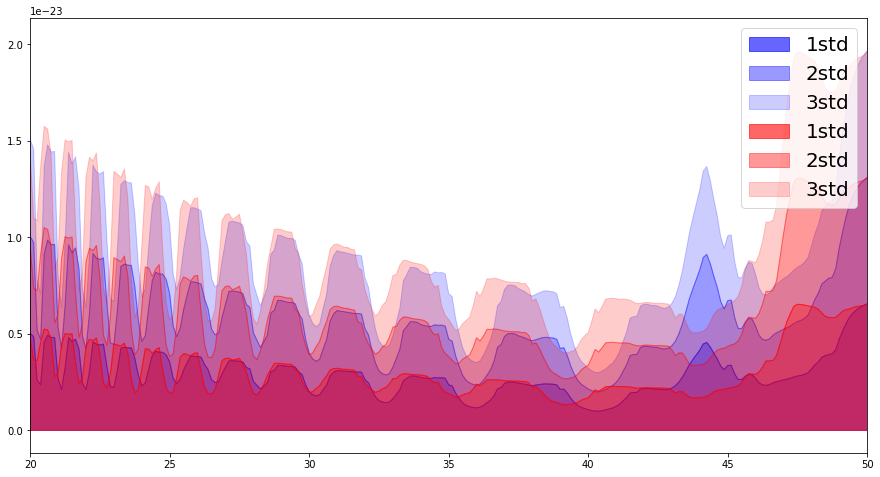

In [31]:
plt.figure(figsize=(15,8))

mode = 'cross'
plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict[mode]), label=f'1std', alpha=0.6, color='b')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict[mode]),2*np.real(error_dict[mode]), alpha=0.4, color='b', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict[mode]),3*np.real(error_dict[mode]), label=f'3std', alpha=0.2, color='b')


plt.fill_between(waveform_generator.frequency_array, np.zeros(len(waveform_generator.frequency_array)), np.real(error_dict2[mode]), label=f'1std', alpha=0.6, color='r')

plt.fill_between(waveform_generator.frequency_array, np.real(error_dict2[mode]),2*np.real(error_dict2[mode]), alpha=0.4, color='r', label=f'2std')

plt.fill_between(waveform_generator.frequency_array, 2*np.real(error_dict2[mode]),3*np.real(error_dict2[mode]), label=f'3std', alpha=0.2, color='r')


plt.legend(fontsize=20)
#plt.xlim(40,100)
plt.xlim(20,50)

In [16]:
len(waveform_generator.frequency_array,)

8193

# Mix context

In [2]:
duration=32
f_lower=10*2
sampling_frequency=4096
ifos = bilby.gw.detector.InterferometerList(['L1'])
det = ifos[0]
det.duration = duration
det.sampling_frequency=sampling_frequency
det.frequency_mask = det.frequency_array>=f_lower
mask = det.frequency_mask
freq_array = det.frequency_array[mask]

injection_parameters = {'chirp_mass': 20,
 'mass_ratio': 1,
 'a_1': 0.38817513918906,
 'a_2': 0.3618136183509149,
 'tilt_1': 1.5721118014736555,
 'tilt_2': 0.6209483780316792,
 'phi_12': 0.497541312882614,
 'phi_jl': 2.727769314864493,
 'theta_jn': 1.2076899194027677,
 'psi': 2.592123436585328,
 'phase': 3.153492039022807,
 'ra': 4.2400911,
 'dec': -0.39120439,
 'luminosity_distance': 320,
 'geocent_time': 1256779567.5339382}

approx = 'IMRPhenomPv2' # IMRPhenomXPHM IMRPhenomPv2
approx_under = 'SEOBNRv4P' # SEOBNRv4PHM SEOBNRv4P
f_ref = 50
f_lower = 20
waveform_arguments1 = dict(waveform_approximant=approx,
                              reference_frequency=f_ref, minimum_frequency=f_lower)
waveform_arguments2 = dict(waveform_approximant=approx_under,
                              reference_frequency=f_ref, minimum_frequency=f_lower)

waveform_generator1 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments1)

waveform_generator2 = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments2)

In [3]:
h_dict_imr = waveform_generator1.frequency_domain_strain(injection_parameters)
h_dict_eob = waveform_generator2.frequency_domain_strain(injection_parameters)

In [5]:
# local
path_local_PHM = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
path_local_P = '/Users/qianhu/Documents/Glasgow/research/np_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'

# cit
path_cit_PHM = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_PHM_q25a8M40_2N10k/'
#path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/FULLFD_IMREOB_P_q25a8M40_2N10k/'
path_cit_P = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/run0211/'
np_model_path = path_cit_P
waveform_generator_np_mix = npgwutils.NPMixWaveformGenerator(model_path=np_model_path,
                                                          context_waveform_generator1=waveform_generator1,
                                                          context_waveform_generator2=waveform_generator2,
                                                          example_det = det,
                                                          device='cpu')



--- Loading plus_real/ConvCNP/run_0 ---

plus_real/ConvCNP/run_0 | best epoch: 97 | train loss: 2142.9471 | valid loss: 1851.4958 | test log likelihood: -2245.4485

--- Loading plus_imag/ConvCNP/run_0 ---

plus_imag/ConvCNP/run_0 | best epoch: 97 | train loss: 1481.3873 | valid loss: 1354.7644 | test log likelihood: -1920.464

--- Loading cross_real/ConvCNP/run_0 ---

cross_real/ConvCNP/run_0 | best epoch: 97 | train loss: 3840.4731 | valid loss: 3490.2203 | test log likelihood: -4204.5559

--- Loading cross_imag/ConvCNP/run_0 ---

cross_imag/ConvCNP/run_0 | best epoch: 97 | train loss: 4689.1334 | valid loss: 4240.0233 | test log likelihood: -5439.4057


In [6]:
h_dict, error_dict = waveform_generator_np_mix.frequency_domain_strain(injection_parameters)


/home/qian.hu/.conda/envs/myigwn-py39/lib/python3.9/site-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [7]:
for key in ['plus', 'cross']:
    h_dict_eob[key] = npgwutils.get_shifted_h2_zeropad(h_dict_imr[key], h_dict_eob[key], det)

(20.0, 50.0)

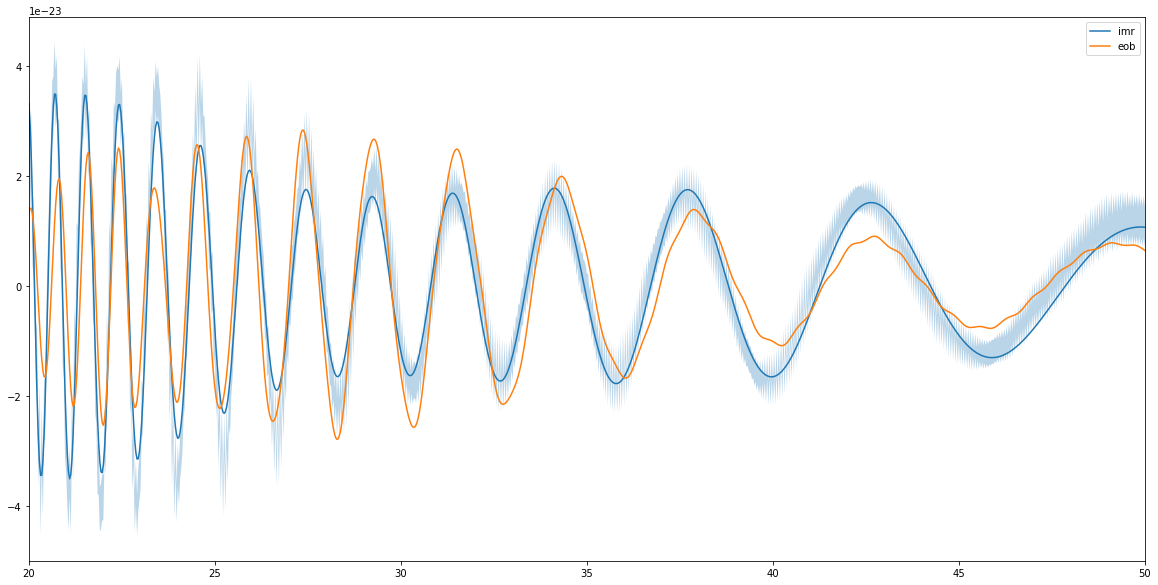

In [8]:
plt.figure(figsize=(20,10))

mode = 'cross'
'''
plt.plot(waveform_generator.frequency_array, np.real(h_dict[mode]), label='np')
plt.fill_between(waveform_generator.frequency_array,
                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
                 alpha=0.3 )
'''
plt.plot(waveform_generator1.frequency_array, np.real(h_dict_imr[mode]), label='imr')
plt.fill_between(waveform_generator1.frequency_array,
                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
                 alpha=0.3 )

plt.plot(waveform_generator2.frequency_array, np.real(h_dict_eob[mode]), label='eob')

plt.legend()
#plt.xlim(40,100)
plt.xlim(20,50)

(20, 2000)

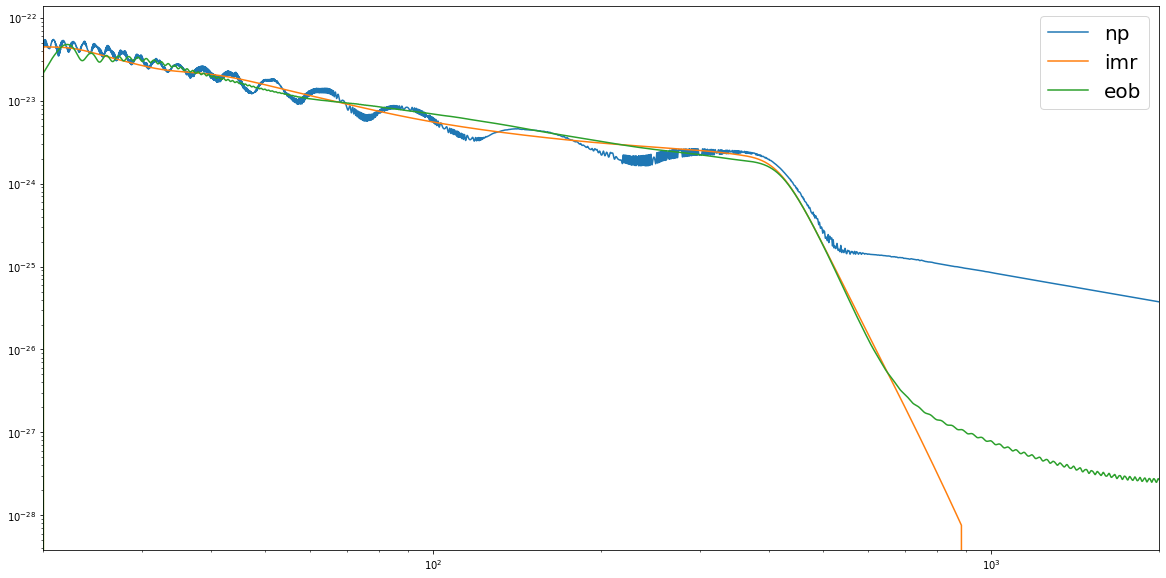

In [9]:
plt.figure(figsize=(20,10))

mode = 'plus'
plt.loglog(waveform_generator1.frequency_array, np.abs(h_dict[mode]), label='np')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict[mode]-error_dict[mode]),np.real(h_dict[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator1.frequency_array, np.abs(h_dict_imr[mode]), label='imr')
#plt.fill_between(waveform_generator.frequency_array,
#                 np.real(h_dict_imr[mode]-error_dict[mode]),np.real(h_dict_imr[mode]+error_dict[mode]),
#                 alpha=0.3 )

plt.loglog(waveform_generator2.frequency_array, np.abs(h_dict_eob[mode]), label='eob')

plt.legend(fontsize=20)
plt.xlim(20,2000)